In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline
from scipy.stats import ks_1samp, uniform, norm, gaussian_kde
import torch
from torchvision.datasets import MNIST
from torchvision import transforms
from torchvision.models import ResNet18_Weights
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from datasets import load_dataset
from joblib import Parallel, delayed

from concurrent.futures import ProcessPoolExecutor, as_completed
from torch.utils.data import Subset, DataLoader

from tqdm import tqdm
from utils import *

import timm

np.random.seed(42)

plt.rcParams.update({
    "font.size": 14,          
    "axes.titlesize": 16,     
    "axes.labelsize": 14,     
    "xtick.labelsize": 12,    
    "ytick.labelsize": 12,
    "legend.fontsize": 12,    
    "figure.titlesize": 18,   
})   


## Learn base classifier

In [2]:
def get_mnist_trained_model(device="cpu", n_per_class=300, batch_size=64, epochs=1, seed=0):
    """Train a small CNN on a balanced MNIST subset."""
    
    # ---------------- Simple CNN with built-in normalization ----------------
    class MNISTModel(torch.nn.Module):
        def __init__(self, mean=0.1307, std=0.3081):
            super().__init__()
            # store mean/std as buffers for internal normalization
            self.register_buffer("mean", torch.tensor([[[mean]]], dtype=torch.float32))
            self.register_buffer("std",  torch.tensor([[[std]]],  dtype=torch.float32))

            # 2 conv layers  dropout → 2 linear layers (standard small CNN)
            self.conv1 = torch.nn.Conv2d(1, 32, 3, 1)
            self.conv2 = torch.nn.Conv2d(32, 64, 3, 1)
            self.dropout1 = torch.nn.Dropout(0.25)
            self.dropout2 = torch.nn.Dropout(0.5)
            self.fc1 = torch.nn.Linear(9216, 128)
            self.fc2 = torch.nn.Linear(128, 10)

        def forward(self, x):
            x = (x - self.mean) / self.std         # normalize within forward
            x = self.conv1(x); x = torch.nn.functional.relu(x)
            x = self.conv2(x); x = torch.nn.functional.relu(x)
            x = torch.nn.functional.max_pool2d(x, 2)
            x = self.dropout1(x)
            x = torch.flatten(x, 1)
            x = self.fc1(x); x = torch.nn.functional.relu(x)
            x = self.dropout2(x)
            return self.fc2(x)

    # reproducibility
    torch.manual_seed(seed); np.random.seed(seed)
    model = MNISTModel().to(device)

    transform = transforms.ToTensor()
    train_full = MNIST(root="./datasets/mnist_data", train=True, download=True, transform=transform)

    # --------- Balanced subset: n_per_class samples per digit ---------
    targets = np.array(train_full.targets)
    idxs = []
    for d in range(10):
        pool = np.where(targets == d)[0]
        take = min(n_per_class, len(pool))
        sel = np.random.choice(pool, size=take, replace=False)
        idxs.append(sel)
    idxs = np.concatenate(idxs)
    np.random.shuffle(idxs)
    train_bal = Subset(train_full, idxs)

    # --------- DataLoader and training loop ---------
    train_loader = DataLoader(train_bal, batch_size=batch_size, shuffle=True)
    opt = torch.optim.Adam(model.parameters())
    crit = torch.nn.CrossEntropyLoss()

    print(f"Training on balanced subset: {len(train_bal)} images "
          f"({n_per_class} per class requested)")

    model.train()
    for epoch in range(epochs):
        pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}")
        for xb, yb in pbar:
            xb, yb = xb.to(device), yb.to(device)
            opt.zero_grad()
            logits = model(xb)  
            loss = crit(logits, yb)
            loss.backward()
            opt.step()
            pbar.set_postfix(loss=f"{loss.item():.4f}")

    model.eval()
    return model


In [3]:
model = get_mnist_trained_model(n_per_class=1000)

Training on balanced subset: 10000 images (1000 per class requested)


Epoch 1/1:   0%|          | 0/157 [00:00<?, ?it/s]

## Generate MNIST dataset

In [4]:
def generate_mnist_dataset(length, changepoint, digit1=1, digit2=7,
                           device="cpu", seed=None, return_labels=False):
    """
    Returns:
      x: torch.float32 tensor [length, 1, 28, 28] in [0,1]
      y: torch.long tensor   [length] with labels (optional)
    Sequence = digit1 for indices 0..changepoint, then digit2 for the rest.
    """
    # Load data
    ds = MNIST(root="./datasets/mnist_data", train=True, download=True, transform=None)
    data = ds.data; targets = ds.targets    

    imgs1 = data[targets == digit1]
    imgs2 = data[targets == digit2]

    # Reproducible shuffles if seed provided
    g = torch.Generator()
    if seed is not None:
        g.manual_seed(seed)
    idx1 = torch.randperm(len(imgs1), generator=g)
    idx2 = torch.randperm(len(imgs2), generator=g)

    n1 = changepoint 
    n2 = length - n1
    if n1 > len(imgs1) or n2 > len(imgs2):
        raise ValueError("Insufficient images for the specified digits and length.")

    x1 = imgs1[idx1[:n1]].to(torch.float32)
    x2 = imgs2[idx2[:n2]].to(torch.float32)
    x  = torch.cat([x1, x2], dim=0).unsqueeze(1) / 255.0    
    x  = x.to(device)

    if return_labels:
        y1 = torch.full((n1,), digit1, dtype=torch.long)
        y2 = torch.full((n2,), digit2, dtype=torch.long)
        y  = torch.cat([y1, y2], dim=0).to(device)
        return x, y
    else:
        return x


In [5]:
n=1000;xi=400
data_mnist = generate_mnist_dataset(n, xi)

### plotting snippets of samples

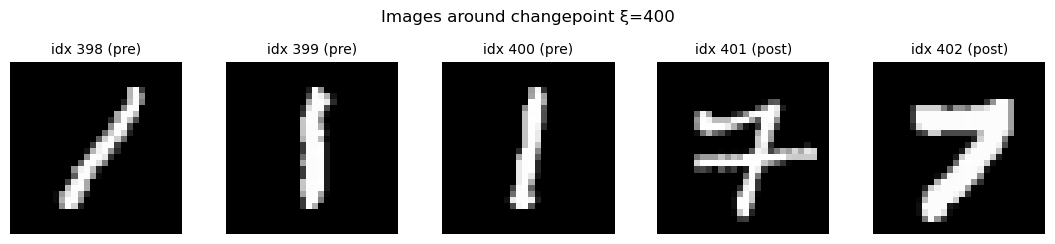

In [6]:
def plot_around_changepoint(x, xi, k=2, *, suptitle=None):
    """
    x: full dataset
    xi: changepoint index (int), meaning last pre-change index is xi,
        first post-change index is xi+1
    k: how many on each side to show (total = 2k+1)
    """
    x = x.detach().cpu()
    n = x.shape[0]

    # indices to show, clipped to [0, n-1]
    idxs = list(range(max(0, xi - k-1), min(n, xi + k)))
    num  = len(idxs)

    plt.figure(figsize=(2.2 * num, 2.5))
    for j, idx in enumerate(idxs, 1):
        img = x[idx, 0].numpy()
        ax = plt.subplot(1, num, j)
        ax.imshow(img, cmap="gray", vmin=0.0, vmax=1.0)
        phase = "pre" if idx < xi else "post"
        ax.set_title(f"idx {idx+1} ({phase})", fontsize=10)
        ax.axis("off")

    if suptitle is None:
        suptitle = f"Images around changepoint ξ={xi}"
    plt.suptitle(suptitle, fontsize=12)
    plt.tight_layout()
    plt.savefig("../images/mnist-samples.pdf", bbox_inches="tight")
    plt.show()

plot_around_changepoint(data_mnist, xi=400, k=2)


## CONCH: performance

In [7]:
@torch.no_grad()
def predict_batch(model: torch.nn.Module, x, device: str = "cpu", T: float = 1.0):
    """
    x: numpy or torch, shape [n, 1, 28, 28], values in [0,1]
    returns: (preds [n], probs [n,10], logits [n,10]) as numpy arrays
    """
    model.eval()
    xb = x.to(device)
    logits = model(xb)              
    logits = logits / T        
    probs  = torch.softmax(logits, dim=1)
    preds  = probs.argmax(dim=1)

    return (
        preds.detach().cpu().numpy(),
        probs.detach().cpu().numpy(),
        logits.detach().cpu().numpy(),
    )

In [8]:
_, _, logits = predict_batch(model, data_mnist, device='cpu', T=1)  # get model logits
p_values_conch_new = compute_p_values(logits, class_before=1, class_after=7, nperm=800, random_state=100)
confidence_set(p_values_conch_new, 0.05)

computing CONCH p-values:   0%|          | 0/999 [00:00<?, ?it/s]

[400]

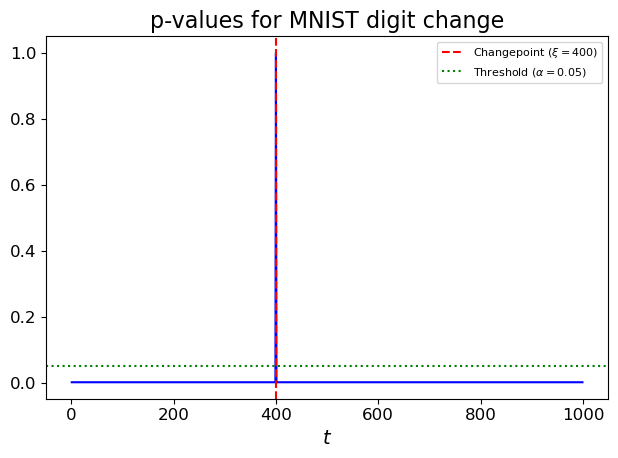

In [9]:
time_indices_p = np.arange(1, n)
plt.plot(time_indices_p, p_values_conch_new, color="blue")
plt.axvline(x=xi, color="red", linestyle="--", label=r"Changepoint ($\xi = 400$)")
plt.axhline(0.05, color="green", linestyle=":", label=r"Threshold ($\alpha = 0.05$)")
plt.xlabel("$t$")
plt.title("p-values for MNIST digit change")

# smaller legend, outside the plot, with light frame
plt.legend(loc="upper right", fontsize=8, frameon=True, framealpha=0.8)

plt.tight_layout()
plt.savefig("../images/mnist-pvalues.pdf", bbox_inches="tight")
plt.show()
